# Import des packages

In [1]:
import torch
from pathlib import Path
import os
import numpy as np
import csv
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import du dataset

In [2]:
data_dir     = "data"
atoms_dir    = os.path.join(data_dir, "atoms", "train")
energies_csv = os.path.join(data_dir, "energies", "train.csv")

energies_dict = {}
with open(energies_csv, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        energies_dict[int(row["id"])] = float(row["energy"])

symbol_to_number = {'H':1,'C':6,'N':7,'O':8,'F':9}
positions_list, charges_list, energies_list = [], [], []

max_atoms = 0
for mol_id, E in sorted(energies_dict.items()):
    xyz = os.path.join(atoms_dir, f"id_{mol_id}.xyz")
    with open(xyz) as f:
        lines = f.readlines()[2:]
    pos, chg = [], []
    for L in lines:
        sp = L.split()
        if len(sp)==4:
            chg.append(symbol_to_number.get(sp[0], 0))
            pos.append([float(x) for x in sp[1:]])
    positions_list.append(np.array(pos))
    charges_list.append(np.array(chg))
    energies_list.append(E)
    max_atoms = max(max_atoms, len(pos))

positions_array = np.zeros((len(positions_list), max_atoms, 3))
charges_array   = np.zeros((len(charges_list),   max_atoms))
for i, (pos, chg) in enumerate(zip(positions_list, charges_list)):
    n = len(chg)
    positions_array[i,:n,:] = pos
    charges_array[i,:n]     = chg
energies_array = np.array(energies_list)

print("Shapes:", positions_array.shape, charges_array.shape, energies_array.shape)

Shapes: (6591, 23, 3) (6591, 23) (6591,)


# Construction du spectre de la matrice de Coulomb

In [3]:
def compute_coulomb_matrix(positions, charges):
    n = len(charges)
    C = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i==j:
                C[i,j] = 0.5 * charges[i]**2.4
            else:
                C[i,j] = charges[i]*charges[j] / np.linalg.norm(positions[i]-positions[j])
    return C

def coulomb_spectrum(positions, charges, Nmax):
    valid = charges>0
    C = compute_coulomb_matrix(positions[valid], charges[valid])
    vals = np.linalg.eigvalsh(C)
    vals = np.sort(vals)[::-1]
    s = np.zeros(Nmax)
    s[:len(vals)] = vals
    return s

spectra = np.array([coulomb_spectrum(positions_array[i],
                                     charges_array[i],
                                     max_atoms)
                    for i in range(len(energies_array))])
print("Spectres shape:", spectra.shape)

Spectres shape: (6591, 23)


## Exemples de spectre

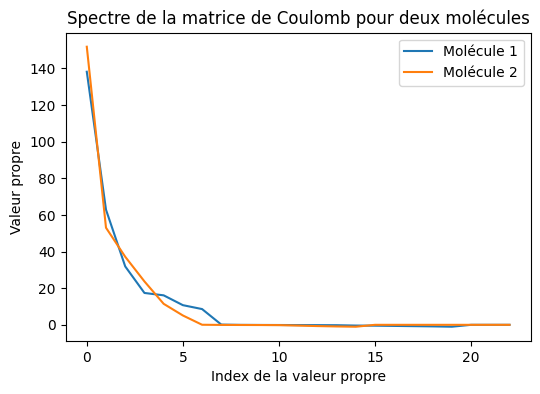

In [4]:

plt.figure(figsize=(6,4))
for idx, mol_idx in enumerate([0, 1]):
    plt.plot(spectra[mol_idx], label=f"Molécule {mol_idx+1}")
plt.xlabel("Index de la valeur propre")
plt.ylabel("Valeur propre")
plt.title("Spectre de la matrice de Coulomb pour deux molécules")
plt.legend()
plt.show()

# Prédiction de l'energie

### Régression linéaire

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    spectra, energies_array, test_size=0.2, random_state=0
)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred)**0.5)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))

RMSE: 2.475483110946253
MAE: 1.8726376893306358
R2 : 0.9536878224889255


### XGBoost

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    spectra, energies_array,
    test_size=0.2,
    random_state=0
)

model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,               
    learning_rate=0.1,             
    max_depth=3,                    
    random_state=0
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("RMSE :", mean_squared_error(y_test, y_pred)**0.5)
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2  :", r2_score(y_test, y_pred))


RMSE : 1.4030481299658546
MAE : 0.9226111665149155
R2  : 0.9851228273061693
